# IRRmodel\*WCM calibration with PSO on KGE of $\sigma^0$

The v5 code is a final, cleaned and commented version.

## Temporal resolution of inputs parameters and calibration
The input datasets can have different temporal resolutions:
- hourly
- daily
- multi-daily

platinum_df tables of Budrio's SWC, rain and irrigation are hourly.
Climate data such as ET and PET are daily. 
Sigma0 values are daily and multi-daily.
NDVI, LAI and other satellite products are multi-daily.

In order to be self-consistent, the model must be calibrated by taking
into account the temporal scale of variation of quantities.
In particular, the soil water balance (SWB) model requires inputs
that can be hourly or daily. Hourly data have to resampled to be
consistent with daily ones, so SWC, rain and irrigation have to be taken
as their mean and sum values. In this way consistency with ET or PET is
ensured.
Once the SWB model has provided daily values, they can be used as inputs in
the water cloud model, that is calibrated against sigma0 values.

It is clear that an optimal calibration would require an hourly SWB estimate
to match with the correct hours of passage of the satellite. On the other
hand, this would require hourly interpolation of ET and PET data. Moreover, at the
moment the computational power required for such a procedure is not possible
to estimate.

In [1]:
import sys
sys.path.append('../')

from modules.funcs import *
from modules.funcs_pso import *
# from modules.pyeto import *

# KEEP YOUR MODELS IN THE NOTEBOOK UNTIL THEY ARE PERFECT
# CAUSE EXTERNAL IMPORT IS AWFUL IN JUPYTER
# from IRRI_WCM.IRRI_WCM_model import *

In [2]:
def pso_calib_wcm(PAR):
    """Ausiliary function for PSO optimization"""
    global inputs
    global irri
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        sig0,KGE = WCM(PAR[i], inputs, units)
        err[i] = 1 - KGE
    return err

In [3]:
def gauss(x, A, mean, dev):
    """Not-normalized, shifted gaussian distribution."""
    import math
    return A*(1/(dev*np.sqrt(2*math.pi)))*np.exp(-(x-mean)**2/(2*dev**2))

def skew_gauss(x, A, mean, dev, alpha):
    """Skew, not-normalized and shifted gaussian distribution."""

    import math
    import scipy.special as sp
    
    pdf = (1/(dev*np.sqrt(2*np.pi)))*np.exp(-pow((x-mean),2)/(2*pow(dev,2)))
    cdf = sp.erfc((-alpha*(x-mean))/(dev*np.sqrt(2)))
    return A*pdf*cdf

def hist_gauss_fit(data, nbins, hist_kwargs, fitline_kwargs,
                   title, density=False,
                   opt_save=False, dir_name='', opt_name='hist_fit',
                   func=gauss,
                  ):
    """Histogram with automatic gaussian fit.
    
    Arguments
    ---------
    - func: object, default gauss
        WARNING: skew_gauss not supported yet    
        
    """

    x = np.linspace(min(data), max(data), 200)
    counts, bins, pads = plt.hist(data, bins=nbins, density=density, **hist_kwargs)
    if func==gauss:
        fit_bounds = [ [0,min(bins),0],
                      [sum(counts)*np.diff(bins)[0],max(bins),abs(max(bins)-min(bins))] ]
    elif func==skew_gauss:
        fit_bounds = [ [0,min(bins),0],
                      [sum(counts)*np.diff(bins)[0],max(bins),abs(max(bins)-min(bins))],
                      # [-10, 10]
                     ]
    else: raise ValueError(f'Func {func} is not a valid option.')
    popt, pcov = curve_fit(func, bins[:-1], counts, method='trf',bounds=fit_bounds, maxfev=1000)
    fit = func(x, *popt)
    plt.plot(x, fit, **fitline_kwargs)
    ylabel = 'Density' if density else 'Counts'; plt.ylabel(ylabel)
    plt.legend(loc='best'); plt.title(title)
    xtext=0.8*(max(x)-min(x))+min(x); ytext=0.5*(max(counts)-min(counts))+min(counts)
    t = plt.text(xtext, ytext,
                 f'tot counts={len(data)}\nmean={popt[1]:.2f}\ndev={popt[2]:.2f} ({popt[2]/abs(popt[1])*100:.1f}%)',
                 ha="center", va="center", size=15,
                 bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))
    
    if opt_save: plt.savefig(dir_name+opt_name+'.png', dpi=300)

# WCM

In [4]:
def WCM(PAR, data_in, units='lin'):
    """Water Cloud Model.
    
    This function simulates backscattering with WCM and returns
    the KGE index to perform its minimization for calibration
    of parameters A,B,C,D.
    WCM is parametrized with a single vegetation descriptor (nominated
    veg, but can be anything).
    Fitting can be performed in linear or dB scale.
    
    
    Inputs
    ------
    - PAR: list
        List of initial guesses for the parameters to calibrate.
    - data_in: list
        List of inputs of observables, that must be in the form:
        [SM,veg,t_deg,obs], being SM = soil moisture,
        veg = Leaf Area Index, t_deg = angle of observation,
        obs = observed total sigma0
    - units: str, default 'linear'
        choose to calibrate the model's parameters in 'linear' or 'db' scale
        
    Return
    ------
    KGE between simulated and observed backscattering.
    
    """

    A,B,C,D = PAR # parameters to fit
    d_sat,SM,veg,theta,obs = data_in # input data
    
    angle = theta*np.pi/180. # angle of observation
    sig0s_dB = C+D*SM # sigma0_soil [dB]
    T2 = np.exp((-2*B*veg)/np.cos(angle)) # attenuation
    sig0v = A*veg*np.cos(angle)*(1-T2) # sigma0_veg [arb]
    
    if units=='lin':
        sig0s = db_lin(sig0s_dB) # sigma0_soil [lin]
        sig0_lin = T2*sig0s+sig0v # sigma0_tot [lin]
        sig0=lin_db(sig0_lin) # sigma0_tot [dB]
    elif units=='db':
        sig0 = T2*sig0s_dB+sig0v # sigma0_tot [db]
    else: raise NameError('Please choose one of the options: lin/db')
    
    OUT=he.evaluator(he.kge, sig0, obs)
    KGE=OUT[0,:];

    return [sig0,KGE]

#----------------------------------------------------------------------------

def SM_fromWCM(PAR, data_in, units='lin'):
    """Inverted WCM for SM estimation."""

    A,B,C,D = PAR # parameters, fitted
    SM,veg,t_deg,obs = data_in # input data
    
    theta = t_deg*np.pi/180. # angle of observation
    T2 = np.exp((-2*B*veg)/np.cos(theta)) # attenuation
    sig0v = A*veg*np.cos(theta)*(1-T2) # sigma0_veg
    
    if units=='lin':
        sig0s_lin = (db_lin(obs)-sig0v)/T2
        SMretr = (lin_db(sig0s_lin)-C)/D
    elif units=='db':
        sig0s = (obs-sig0v)/T2
        SMretr = (sig0s-C)/D 
    
    OUT=he.evaluator(he.kge, SMretr, SM)
    KGE=OUT[0,:];

    return [SMretr,KGE]

# Global

In [5]:
filename = f'irr_obs_'

# Data pre-processing

Input data formatting convention:
- ausiliary variables for extraction of data (directory name, file name, etc...)
- extraction into pd dataframe
- cleaning, resampling: drop unnecessary columns, set index to daily DateIndex

**Time resampling consistency**

- $\sigma^0$ values are extracted with a timestamp aaaa-mm-dd hh:mm:ss with frequency 'H' (hourly), then are rounded by `.round()` to the midnight of the nearest day to have frequency 'D' (daily), e.g. a passage at 7 am on 1st july is rounded to 0 am of 1st july, a passage at 7 pm would be rounded at 0 am of 2nd july.
- many quantities need to be resampled from hourly to daily datasets: use the `.resample()` method on a dataframe with hourly DatetimeIndex and pass the argument `origin='end_day'`. In this way, for each day X, data are considered between hours 1 and 24(=0 of day X+1) and the timestamp assigned is the one of the day X+1 (on which the operation ends). 

In [6]:
print('Starting...\n'
      +'#-------------------------------------------------------------\n'
      #+'Use of satellite-derived SM is provided for comparison, not calibration.\n'
     )
verbose = True if input("Verbose data extraction? (Describe datasets/files) [y/n]")=='y' else False

params = []; norma = ''

print('\n#-------------SWB model parameters-------------')
irri = True if input('Do you want to calibrate irrigation as well as soil moisture? '
                     +'Answer yes will treat irrigation observations as a benchmark '
                     +'for model performance only. [[]/(any)')=='' else False
year = int(input('Do you want to calibrate on year 2017 or 2020? [2017/2020]'))

print('\n#-------------WCM model parameters-------------')
units = input('Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db]')


print('\n#------------Optimization parameters-----------')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
verbose_calib = True if input('Verbose during calibration? [[]/(any)]')=='' else False

Starting...
#-------------------------------------------------------------



Verbose data extraction? (Describe datasets/files) [y/n] n



#-------------SWB model parameters-------------


Do you want to calibrate irrigation as well as soil moisture? Answer yes will treat irrigation observations as a benchmark for model performance only. [[]/(any) n
Do you want to calibrate on year 2017 or 2020? [2017/2020] 2017



#-------------WCM model parameters-------------


Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db] db



#------------Optimization parameters-----------


Number of runs? (10 is min to study distribution of parameters.)  50
Number of particles:  20
Number of optimization steps:  100
Global or Local PSO optimizer? [[global]/local]  
Verbose during calibration? [[]/(any)] 


## IRRmodel

Frequency: daily

Inputs:
- rain (sum, end of day)
- et0 (daily)

Comparisons:
- irrigation (sum, end of day)
- soil moisture (mean, end of day)

In [7]:
#----------------------------------------------------------------------------
# Field data from TEST_SITE
# Daily data from 2015 to 2017, various gaps

# Data extracted:
# - rain (as input SWB)
# - EPOT = potential evapotranspiration (as input SWB)

namesite = 'ITALY_BUDRIO'
siteID = '5'
namefig = namesite+'_'+siteID

site_df = xr.open_dataset(f'..\Inputs\TEST_SITE\TEST_SITE_{namesite}.nc',
                         engine='netcdf4').to_dataframe();
site_df = site_df.rename(columns={'Time_days':'Date'})
site_df = site_df.set_index('Date')
site_df = site_df.loc[:,[col for col in site_df.columns if col.endswith(siteID)]]
if verbose: site_df.info()

In [8]:
#----------------------------------------------------------------------------
# Budrio field data from platinum_df tables

# Freq: H
# Data extracted:
# - SWC (as input SWB/comparison)
# - rain (as input SWB)
# - irrigation (as input SWB)
# - temperature (as input SWB, ET0 estimate)

platinum_df = pd.ExcelFile('..\Inputs\Platinum_Budrio.xlsx', engine='openpyxl')
if year==2017: sheet='2017_1h'
if year==2020: sheet='2020_1h'
platinum_df = platinum_df.parse(sheet)
# platinum_df = pd.concat([platinum_df.parse('2017_1h'), platinum_df.parse('2020_1h')])

# Column 'Date' contains date+hour = hourly information
# Column 'Data' contains only date = daily information
platinum_df['Ora_1'] = pd.to_datetime(platinum_df['Ora'].astype('str')).apply(lambda x: x.time())
platinum_df['Data_1'] = pd.to_datetime(platinum_df['Data'].astype('str')).apply(lambda x: x.date())
platinum_df['Datetime'] = platinum_df.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum_df = platinum_df.drop(['ID', 'Data', 'Ora', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
platinum_df = platinum_df.set_index('Datetime')
platinum_resampled = platinum_df.resample('D', origin='end_day')
if verbose: platinum_df.info()

In [9]:
#----------------------------------------------------------------------------
# Budrio field data from meteo tables

# Freq: H
# Data extracted:
# none
# Needed for eto from FAO PM 

meteo_df = pd.ExcelFile('..\Inputs\Budrio_Meteo.xlsx', engine='openpyxl')
meteo_df = meteo_df.parse(str(year))
# meteo_df = pd.concat([meteo_df.parse('2017'), meteo_df.parse('2020')]).set_index('ID')

# Column 'Date' contains date+hour = hourly information
meteo_df['Datetime'] = meteo_df.apply(lambda r : dtt.datetime.combine(r['Data'],r['Ora']),1)
meteo_df = meteo_df.set_index('Datetime')
meteo_df = meteo_df.drop(['Data', 'Ora'],axis=1)

if verbose: meteo_df.info()
# meteo_df.head()

In [10]:
# Budrio database
# Freq: H
# Merging of Platinum+Meteo

meteo_h = pd.merge(right=platinum_df, left=meteo_df, on='Datetime')
if verbose: meteo_h.info()

After long and deep thinking \
and at least ten coffee drinking \
I have reached the conclusion \
that the best possible solution \
for the inputs' database \
is in fact the easiest case: \
take each column as it is, \
resample, sum or take the mean, \
give a name to every one \
and please take it easy for once!

In [11]:
# Build inputs as timeseries (using the nominal function)
# timeseries(dates, data) -> matrix[columns={dates, data}]

In [12]:
# ET0 calculation

import datetime
import sys

sys.path.append('../')
from modules.pyeto.pyeto import *

def hargre(lat_deg, dates, temp_min, temp_max, temp_mean):
    """Hargreaves-Samani model for ET0 estimation from temperature input.
    
    Params
    ------
    - lat_deg: float
    - dates: timestamp
    - temp_*: float
    
    
    """
    lat = deg2rad(lat_deg)  # Convert latitude in degrees to radians
    day_of_year = dates.dayofyear
    sol_decli = sol_dec(day_of_year) # Solar declination
    sha = sunset_hour_angle(lat, sol_decli)
    ird = inv_rel_dist_earth_sun(day_of_year)
    et_radia = et_rad(lat, sol_decli, sha, ird) # Extraterrestrial radiation
    return hargreaves(temp_min, temp_max, temp_mean, et_radia)

In [13]:
from IRRI_WCM.EPOT_Hargreaves_pyeto import *

lat_deg = 44.570842547510622 # latitude of Budrio (deg)
temp_min = platinum_resampled.min()['Temperatura[°C]'].values
temp_max = platinum_resampled.max()['Temperatura[°C]'].values
temp_mean = platinum_resampled.mean()['Temperatura[°C]'].values
dates = platinum_resampled.asfreq().index
eto = timeseries( dates,
                 [ hargre(lat_deg, dates[i] , temp_min[i], temp_max[i], temp_mean[i])
                  for i in range(len(dates)) ] )
eto_df = pd.DataFrame(eto).rename(columns={0:'Date',1:'EPOT'}).set_index('Date')
if verbose: eto_df.info()

## WCM

Frequency: multi-daily

Inputs:
- $\sigma^0$, $\theta$ (hourly, rounded to nearest midnight)
- vegetation descriptors (NDVI, LAI, CR) (average, daily)

In [14]:
#----------------------------------------------------------------------------
# Sigma0 values

# Freq: D
# Daily values of backscattering from 2014 to 2022 (complete S1 series)
# Data extracted:
# - sigma0 values, VV and VH
# - angle of incidence of reference orbit (nearest to 40°)

sigma_df = pd.read_csv('..\Data\\budrio-half.csv', delimiter='\t');
sigma_df['Datetime'] = sigma_df.Date.apply(lambda x : pd.to_datetime(x))
sigma_df.Date = sigma_df.Date.apply(lambda x : pd.to_datetime(x).round(freq='D'))
sigma_df = sigma_df.set_index('Date')
if verbose: sigma_df.info()

In [15]:
#----------------------------------------------------------------------------
# NDVI values

# Freq: D
# Daily values of NDVI from 2017-4-24 to 2023-1-13 (complete S2 series)
# Data extracted:
# - NDVI (daily, interpolated)

ndvi_df = pd.read_csv('..\Data\\budrio-half_NDVI.csv', delimiter='\t');
ndvi_df.Date = ndvi_df.Date.apply(lambda x : pd.to_datetime(x))
ndvi_df = ndvi_df.set_index('Date')
if verbose: ndvi_df.info()

# Input data

In [16]:
# Input SWB
# Frequency: daily
# Data:
# - rain (sum, end of day) from platinum_resampled
# - eto (daily) from eto_df

input_swb = pd.merge(right=eto_df, left=platinum_resampled.sum(),
                     right_on='Date', left_on='Datetime', right_index=True)\
                    .drop(['SWC[m3/m3]','Temperatura[°C]'], axis=1)\
                    .rename(columns={'Pioggia[mm]':'Pioggia[mm]_sum',
                                     'Irrigazione[mm]':'Irrigazione[mm]_sum'})
swc = platinum_resampled.mean()['SWC[m3/m3]']
input_swb['SWC[m3/m3]_mean'] = swc
if verbose: input_swb.info()

In [17]:
# Input WCM
# Frequency: daily
# Data:
# - sigma0 (multi-daily, rounded at nearest midnight)
# - NDVI (daily, interpolated)
# Merging is performed without any time offset, considering that the change
# in ndvi values anywhere is very small from one day to another 

input_wcm_sat = pd.merge(right=sigma_df, left=ndvi_df, on='Date', how='right')

In [18]:
input_wcm_sat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2014-10-12 to 2022-11-28
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NDVI         916 non-null    float64       
 1   Geometry_x   916 non-null    object        
 2   Angle[°]     1150 non-null   float64       
 3   Geometry_y   1150 non-null   object        
 4   Orb          1150 non-null   int64         
 5   Pass         1150 non-null   object        
 6   VV_norm[dB]  1150 non-null   float64       
 7   VH_norm[dB]  1150 non-null   float64       
 8   CR           1150 non-null   float64       
 9   Datetime     1150 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 98.8+ KB


In [19]:
input_wcm = pd.merge(right=input_wcm_sat, left=platinum_df, on='Datetime',
                     how='inner')\
            .drop(['Pioggia[mm]','Irrigazione[mm]','Temperatura[°C]',
                   'Geometry_x'], axis=1)\
            .rename(columns={'SWC[m3/m3]':'SWC_h', 'Geometry_y':'Geometry',
                             'VV_norm[dB]':'VV', 'VH_norm[dB]':'VH', 'Angle[°]':'Angle'})

#----------------------------------------------------------------------------
# Convenience method for printing labels of columns that are interpolated
# only on the basis of their length being less than the length of the df,
# and not taking into consideration if they are being interpolated or extr

# print('The following columns will be interpolated: '
#       +f'{[x for x in input_wcm if len(input_wcm[x].dropna())<len(input_wcm)]}\n')
# if input('Proceed? [y/n]')!='y':
#      raise NameError('Stop and stare! I think I\'m going but I don\'t know where!')
#----------------------------------------------------------------------------

print(
    '\nNDVI values are limited below at the 24 of april 2017, so they are'+
    'backward propagated for 30 days in order to cover the whole Budrio period.'+
    ' There is a gap in SWC values: this gap is not interpolated but is used to'+
    'eliminate those days with nan SM values from the days of passage of the'+
    'satellite.\n'
)
input_wcm.NDVI.interpolate(method='bfill',
                           limit_direction='backward',
                           limit=30,
                           # limit_area='inside', # THIS WORKS VERY BADLY IN EVERY WAY
                           inplace=True)

input_wcm.index = input_wcm.Datetime.round('D')
input_wcm.dropna(inplace=True)
if verbose: input_wcm.info()


NDVI values are limited below at the 24 of april 2017, so they arebackward propagated for 30 days in order to cover the whole Budrio period. There is a gap in SWC values: this gap is not interpolated but is used toeliminate those days with nan SM values from the days of passage of thesatellite.



In [20]:
# List of 2017 and 2020 dates

# Complete days in 2017, 2020
d = [x for x in input_swb.index if x.year==year]
     
# Days of passage of satellite, intersect with complete days
set1 = {x for x in input_swb.index}; set2 = {x for x in input_wcm.index};
intersect = np.sort(np.array([*set1.intersection(set2)]))
d_sat = [x for x in intersect if x.year==year]
h_sat = [x for x in input_wcm.Datetime if x.year==year]

In [21]:
P       = input_swb.loc[d]['Pioggia[mm]_sum'] # [mm]
IRR_obs = input_swb.loc[d]['Irrigazione[mm]_sum'] # [mm]
EPOT    = input_swb.loc[d]['EPOT'] # [mm/day]
WW_d    = input_swb.loc[d]['SWC[m3/m3]_mean'] # daily, mean (observed) [m3/m3]
WW_h    = input_wcm.loc[d_sat]['SWC_h'].interpolate(method='linear') # punctual at hour (observed) [m3/m3]
veg     = input_wcm.loc[d_sat]['NDVI'] # [-]
theta   = input_wcm.loc[d_sat]['Angle'] # [°]
VV      = input_wcm.loc[d_sat]['VV'] # [dB]
VH      = input_wcm.loc[d_sat]['VH'] # [dB]
CR      = input_wcm.loc[d_sat]['CR'] # [-]

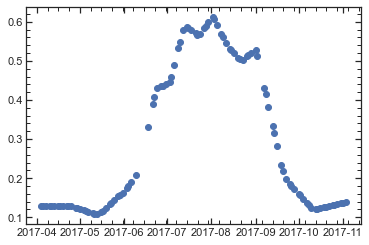

In [22]:
plt.plot(veg, ls='', marker='o')

# Calibration WCM

In [23]:
# Calibration WCM

print('Starting calibration of WCM...\n'+
      '#-------------------------------------------------------------\n')

A=0.3; B=3; C=-15; D=40 # guess params for WCM

PAR     = [A, B, C, D]
if units=='lin': PAR_str = ['A_wcm', 'B_wcm', 'C_wcm', 'D_wcm']
elif units=='db': PAR_str = ['A_wcm_db', 'B_wcm_db', 'C_wcm_db', 'D_wcm_db']
inputs  = [d_sat, WW_h, veg, theta, VV]
units   = units

if units=='lin':
    bounds = (
        np.array([.01, .01, -35,  1]), # low
        np.array([  5,  10,   0, 60]), # up
    )
elif units=='db':
    bounds = (
        np.array([ -15, .01, -35,  1]), # # low
        np.array([-0.1,  10,   0, 60]), # # up
    )
else: raise NameError(f'Scale can only be lin or db but {scale} was provided.')

#-----------------------------------------------------------------------------
from pyswarms.backend.handlers import OptionsHandler

for i in range(int(nrun)):
    if (optim=='global')or(optim==''):
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 2.05, 'c2': 2.05, 'w': 0.6}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles),
                                            dimensions=len(PAR),
                                            options=options,
                                            bounds=bounds,
                                            oh_strategy={"w":'exp_decay',
                                                         'c1':'lin_variation',
                                                         'c2':'lin_variation'}
                                           )
    elif optim=='local':
        options = {'c1': 2, 'c2': 2, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norma }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles,
                                           dimensions=len(PAR),
                                           options=options,
                                           bounds=bounds,
                                           oh_strategy={"w":'exp_decay',
                                                        'c1':'lin_variation',
                                                        'c2':'lin_variation'})
    else: raise NameError('Please provide an accepted option.')
    
    cost, PARn = optimizer.optimize(pso_calib_wcm, n_step, verbose=verbose)#, **PAR)
    params.append(PARn)
    i+=1

#-----------------------------------------------------------------------------
# Model validation
#-----------------------------------------------------------------------------
sigma0, KGE = WCM(PARn, inputs, units)
print('PAR = [A, B, C, D]\n', PARn)
timestr = time.strftime("%y%m%d-%H%M%S")

Starting calibration of WCM...
#-------------------------------------------------------------

PAR = [A, B, C, D]
 [-14.99785034   0.87117391 -23.36673563  49.96148274]


# Parameters' study

Plot parameters distributions? [y/n] y
Save plots? [y/n] y


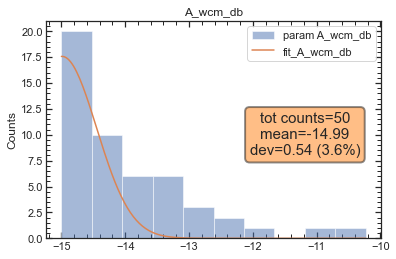

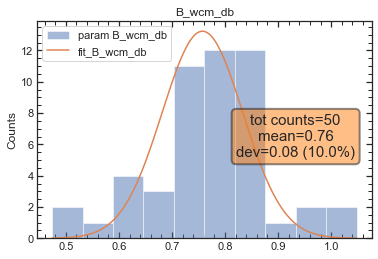

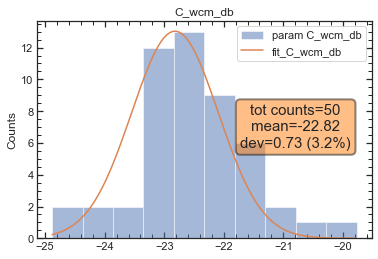

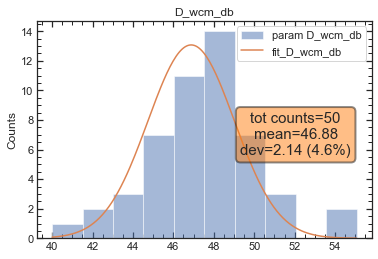

In [24]:
#-----------------------------------------------------------------------------
# Study distribution of parameters
#-----------------------------------------------------------------------------
matrix = np.array(
    [
        np.array(
            [ params[i][j] for i in range(nrun) ])
        for j in range(len(PAR))
    ]
)

PAR_dict = { PAR_str[i]:matrix[i] for i in range(len(PAR)) }

if (int(nrun)>9)and(input('Plot parameters distributions? [y/n]')=='y'):
    opt_save=True if input('Save plots? [y/n]')=='y' else False
    for i in range(len(PAR)):
        hist_kwargs={'alpha':.5, 'label':f'param {PAR_str[i]}'}
        fitline_kwargs={'linestyle':'-', 'label':f'fit_{PAR_str[i]}'}
        data = PAR_dict[PAR_str[i]]
        nbins = 10 if nrun<100 else np.sqrt(nrun)-4
        hist_gauss_fit(data, nbins=10, hist_kwargs=hist_kwargs, fitline_kwargs=fitline_kwargs,
                       title=f'{PAR_str[i]}', density=False,
                       opt_save=opt_save, dir_name='Plot\\', opt_name=f'hist_{PAR_str[i]}',
                       func=gauss)
        plt.show()

# Model output - plots sim VS obs for SM, sigma0

In [27]:
# Standardized plotting

if input('Do you want to plot standard, mean parameters? [y/n]')=='y':
    # PAR     = [A, B, C, D]
    PARn = [-14.99, 0.76, -22.82, 46.88]
    sigma0,KGE = WCM(PARn, inputs, units)

Do you want to plot standard, mean parameters? [y/n] y


Save simulated VS observed soil moisture? [[]/(any)] 


RMSE = 1.785448419784801
R= 0.5108070802616532
bias = -0.3154624246756553
KGE= 0.5096869572719097


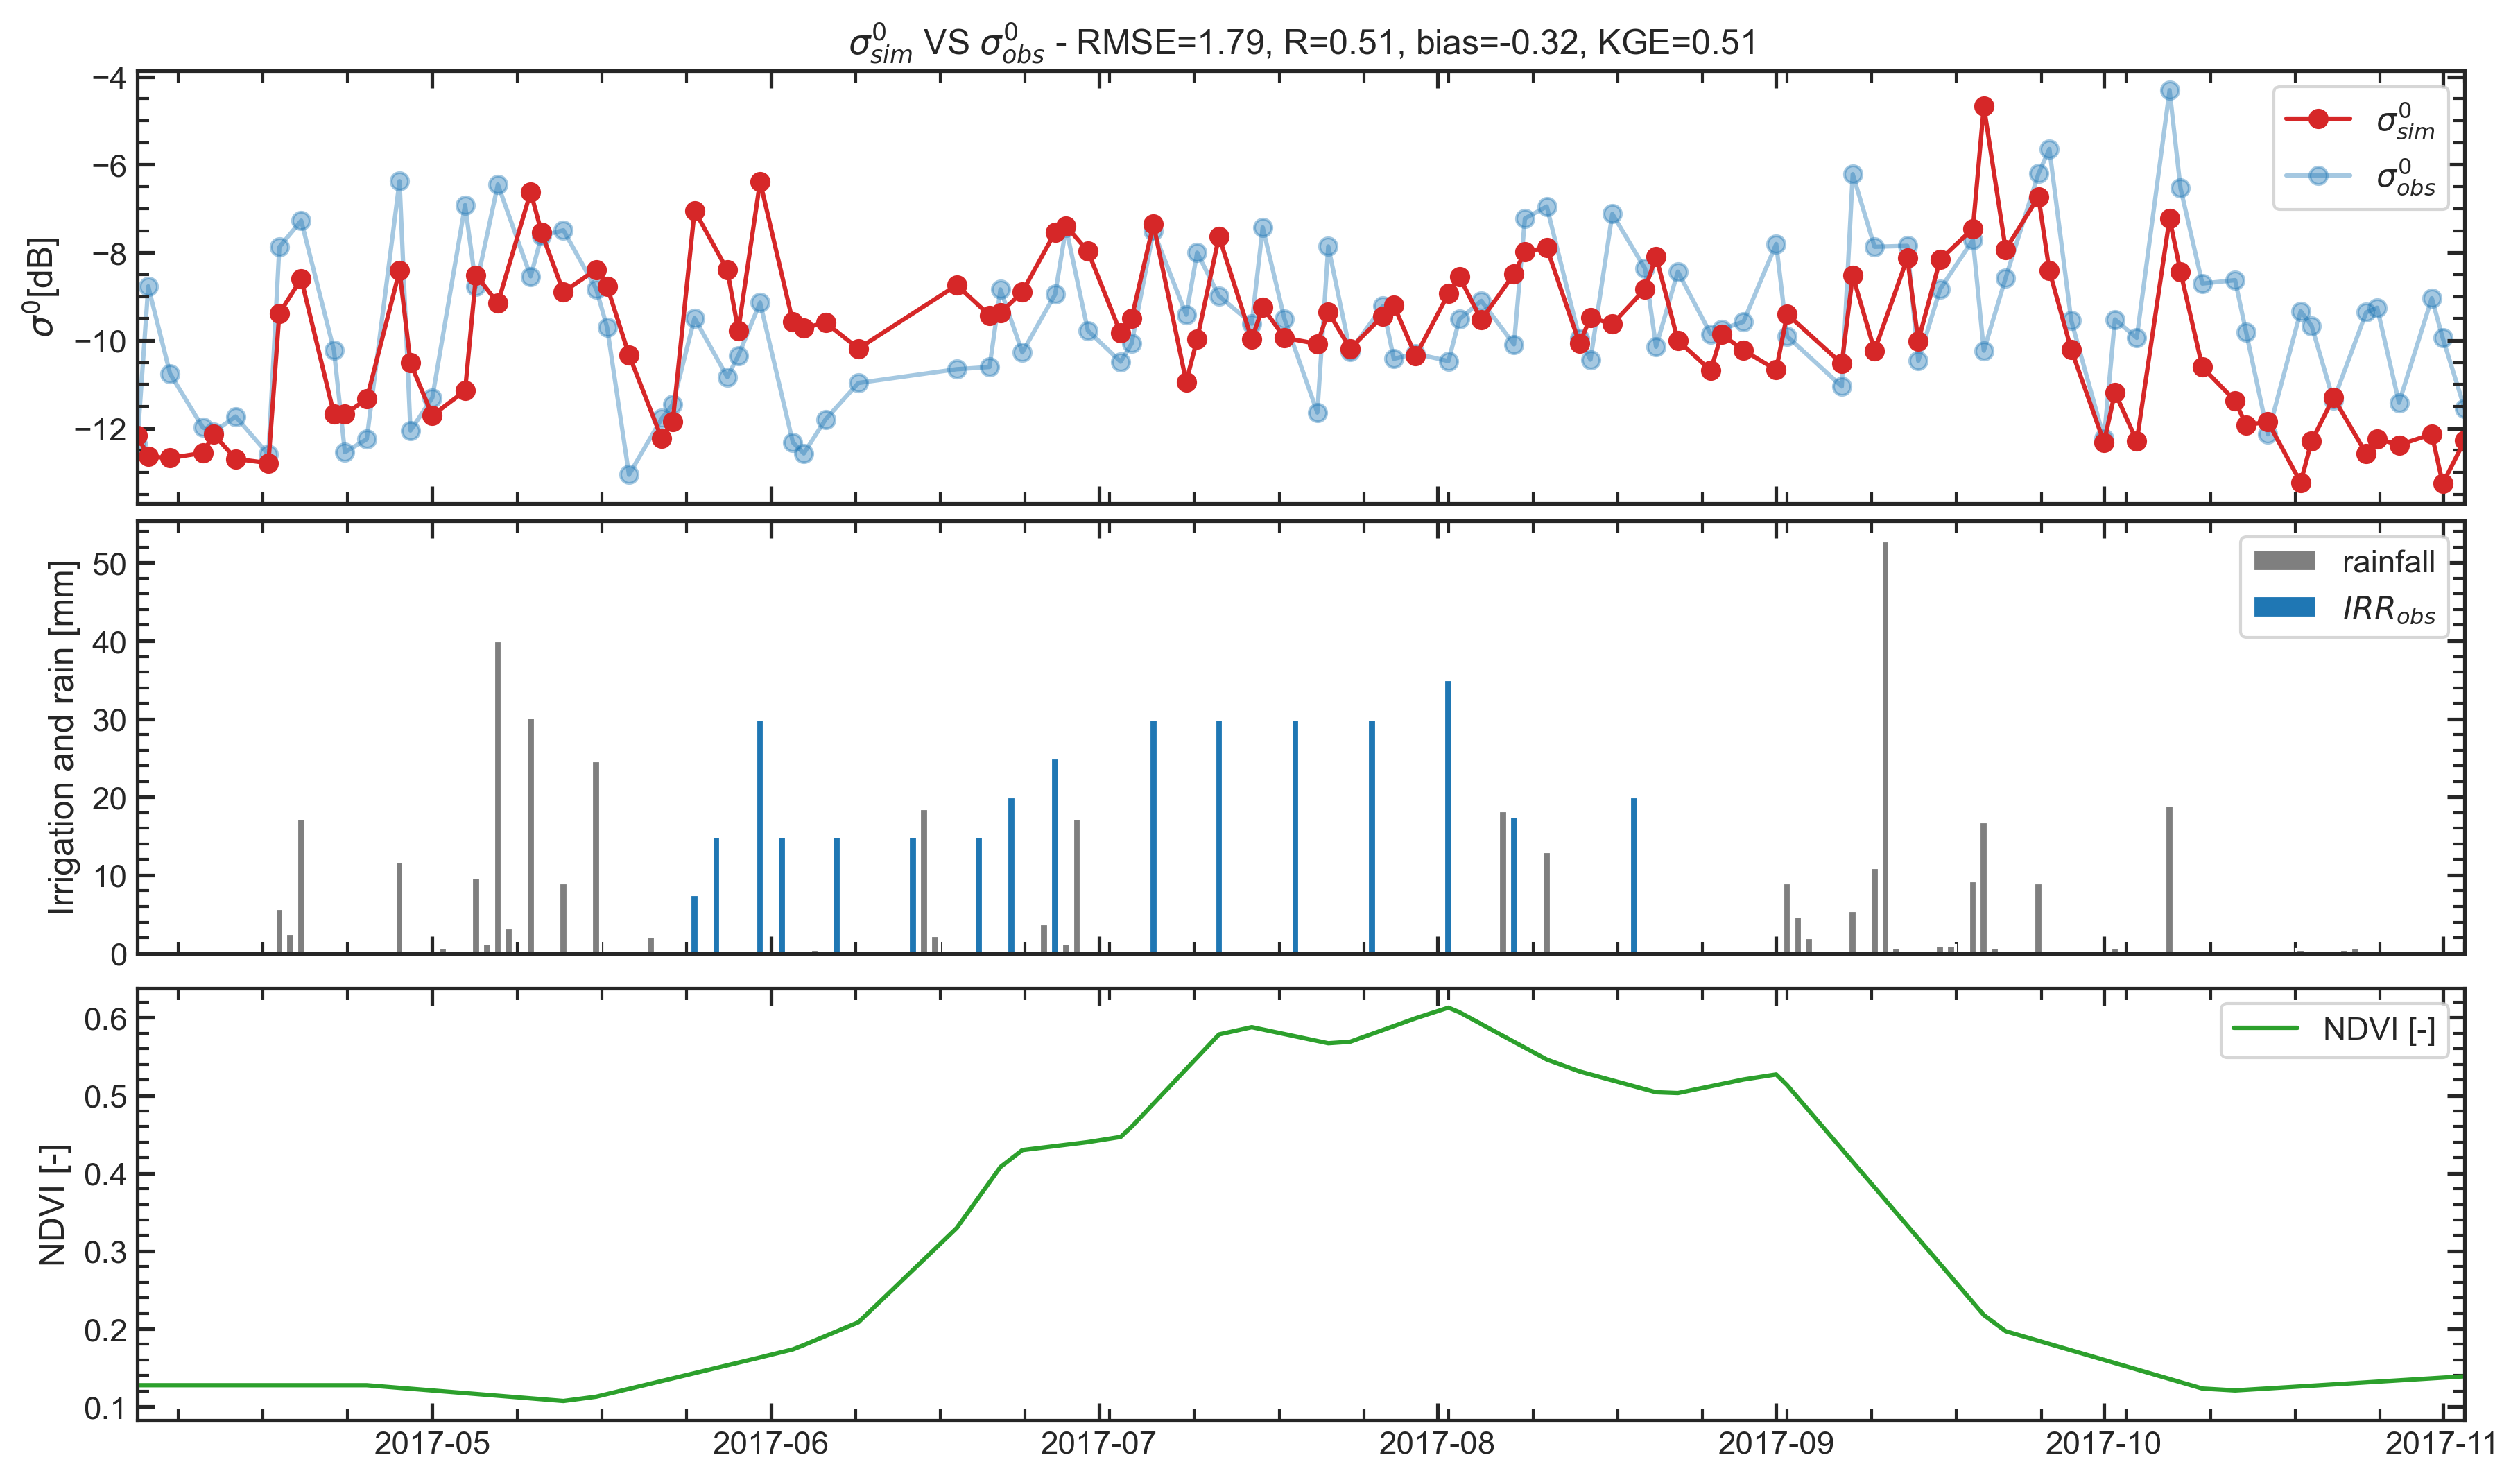

In [28]:
obs = VV; obs_label=r'$\sigma^0_{obs}$'
sim = sigma0; sim_label=r'$\sigma^0_{sim}$'
labely = r'$\sigma^0$[dB]'
times = d_sat
marker='o'; linestyle='-'

opt_save_plot = True if input('Save simulated VS observed soil moisture? [[]/(any)]')=='' else False

#-----------------------------------------------------------------------------
# Model performance on sigma0 and plot
#-----------------------------------------------------------------------------

# NS=1-np.nansum((q1-q2)**2)/np.nansum((q2-np.nanmean(q2))**2)
# NS_radQ=1-np.nansum((np.sqrt(q1+0.00001)-np.sqrt(q2+0.00001))**2)/np.nansum((np.sqrt(q2+0.00001)-np.nanmean(np.sqrt(q2+0.00001)))**2)
# NS_lnQ=1-np.nansum((np.log(q1+0.0001)-np.log(q2+0.0001))**2)/np.nansum((np.log(q2+0.0001)-np.nanmean(np.log(q2+0.0001)))**2)
# NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
# NS_radQ=NS_radQ.real; # print(NS_radQ)

RMSE=np.mean((sim-obs)**2)**0.5; print('RMSE =', RMSE)
R=np.corrcoef(sim,obs)[0][1]; print('R=', R)
B=bias(sim,obs); print('bias =', B)
print('KGE=', KGE[0])

fig, ax = plt.subplots(3, 1,constrained_layout=True,figsize=(12, 7), sharex=True,dpi=300,)

title=f'{sim_label} VS {obs_label} - RMSE={RMSE:.2f}, R={R:.2f}, bias={B:.2f}, KGE={KGE[0]:.2f}'

ax[0].set_xlim(xmin=times[0], xmax=times[len(times)-1])
ax[0].plot(times, sim, c='tab:red', label=sim_label,
           linestyle=linestyle, marker=marker, )#alpha=.4, zorder=-1)
ax[0].plot(times, obs, c='tab:blue', label=obs_label,
           linestyle=linestyle, marker=marker, alpha=.4, zorder=-1)
ax[0].legend(loc='upper right')
ax[0].set_title(title)
ax[0].set_ylabel(labely)

ax[1].bar(d, P, color='tab:gray', label=r'rainfall')
ax[1].bar(d, IRR_obs, color='tab:blue', label=r'$IRR_{obs}$', zorder=2)
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Irrigation and rain [mm]')

ax[2].plot(times, veg, label='NDVI [-]', color='tab:green')
ax[2].legend(loc='upper right')
ax[2].set_ylabel('NDVI [-]')

name=''
if opt_save_plot==True:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    name = filename+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    plt.savefig('Plot\\'+name+'sigma0.png')